## Imports

In [ ]:
!git clone https://github.com/rmnigm/qber-forecasting.git

In [ ]:
!pip install catboost

In [91]:
import collections
import math
import os
import pathlib
import random


import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import scipy.stats as sps

import statsmodels as sm

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler

from tqdm.notebook import tqdm
from xgboost import XGBRegressor

In [4]:
seed = 123456
random.seed(seed)
np.random.seed(seed)

## Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
columns = {
    1: 'blockId',
    2: 'frameIdx',
    3: 'frameError',
    4: 'byDecoyEst',
    5: 'byDecoyZ',
    6: 'byVacuumZ',
    7: 'nmuSend',
    8: 'nnuSend',
    9: 'nlSend',
    10: 'nmuReg',
    11: 'nnuReg',
    12: 'nlReg',
    13: 'roundDistribution',
    14: 'maintenanceFlag',
    16: 'ema_est',
    17: 'ema_f_ec',
    19: 'vema_est',
    20: 'vema_f_ec',
    22: 'ml_est',
    23: 'ml_f_ec',
    25: 'phys_est',
    26: 'phys_f_ec',
}

In [7]:
data = pl.read_csv('/content/drive/MyDrive/Datasets/qber/frames_errors_12-03.csv', has_header=False)

In [8]:
data = data[:, [k-1 for k in columns.keys()]]
data.columns = list(columns.values())
data = data.select(
    pl.col('vema_f_ec').cast(float).alias('vema_f_ec'),
    pl.col('phys_f_ec').cast(float).alias('phys_f_ec'),
    pl.col('ema_f_ec').cast(float).alias('ema_f_ec'),
    pl.col('ml_f_ec').cast(float).alias('ml_f_ec'),
    pl.col('vema_est').cast(float).alias('vema_est'),
    pl.col('phys_est').cast(float).alias('phys_est'),
    pl.col('ema_est').cast(float).alias('ema_est'),
    pl.col('ml_est').cast(float).alias('ml_est'),
    pl.col('frameError').alias('qber_mu'),
    pl.col('byDecoyEst').alias('qber_prob_model'),
    pl.col('byDecoyZ').alias('qber_nu_1'),
    pl.col('byVacuumZ').alias('qber_nu_2'),
    (pl.col('nmuReg') /  pl.col('nmuSend')).alias('q_mu'),
    (pl.col('nnuReg') /  pl.col('nnuSend')).alias('q_nu_1'),
    (pl.col('nlReg') /  pl.col('nlSend')).alias('q_nu_2'),
    pl.col('maintenanceFlag').alias('maintenance'),
    (pl.col('frameError') - pl.col('ml_est')).abs().alias('ml_err'),
    (pl.col('frameError') - pl.col('ema_est')).abs().alias('ema_err'),
    (pl.col('frameError') - pl.col('vema_est')).abs().alias('vema_err'),
    (pl.col('frameError') - pl.col('phys_est')).abs().alias('phys_err'),
)
ts = data['qber_mu']
ema_ts = data['ema_est']

In [9]:
def calculate_offset_limit(offset, limit, length) -> tuple[int, int]:
    if offset is None:
      offset = 0
    else:
      offset = offset if offset >= 1 else int(offset * length)
    if limit is None:
      limit = length
    else:
      limit = limit if limit >= 1 else int(limit * length)
    return offset, limit

In [10]:
def build_from_dataframe(
    data: pl.DataFrame,
    window_size: int,
    dtype: np.dtype = np.float32,
    columns: list[str] | None = None,
    offset: int | float = None,
    limit: int | float = None) -> tuple[np.ndarray, np.ndarray]:
    length = len(data)
    offset, limit = calculate_offset_limit(offset, limit, length)
    columns = columns or data.columns
    data = (
        data
        .select(columns)
        .slice(offset, limit)
    )
    data_array = data.to_numpy()
    dataset = np.lib.stride_tricks.sliding_window_view(
        data_array,
        window_size + 1,
        axis=0
        )
    return dataset

In [45]:
feature_columns = [
    'qber_mu',
    # 'q_mu',
    # 'q_nu_1',
    # 'q_nu_2',
    'maintenance',
]

window_size = 7

In [52]:
train_data = build_from_dataframe(data=data, window_size=window_size, limit=0.75, columns=feature_columns)
test_data = build_from_dataframe(data=data, window_size=window_size, offset=0.75, columns=feature_columns)

train_x, train_y = train_data[:, :, :-1], train_data[:, 0, -1]
test_x, test_y = test_data[:, :, :-1], test_data[:, 0, -1]

In [53]:
full_data = build_from_dataframe(data=data, window_size=window_size, columns=feature_columns)
X, y = full_data[:, :, :-1], full_data[:, 0, -1]

In [14]:
import scipy.stats as ss

In [15]:
data[['qber_mu', 'qber_prob_model', 'qber_nu_1', 'qber_nu_2', 'q_mu', 'q_nu_1', 'q_nu_2']].corr()

qber_mu,qber_prob_model,qber_nu_1,qber_nu_2,q_mu,q_nu_1,q_nu_2
f64,f64,f64,f64,f64,f64,f64
1.0,-0.071362,0.025059,0.003316,-0.217253,-0.232522,-0.217898
-0.071362,1.0,0.198341,0.184253,-0.115986,-0.130453,-0.129976
0.025059,0.198341,1.0,0.496225,-0.341003,-0.367585,-0.34922
0.003316,0.184253,0.496225,1.0,-0.372281,-0.45833,-0.458868
-0.217253,-0.115986,-0.341003,-0.372281,1.0,0.91173,0.749103
-0.232522,-0.130453,-0.367585,-0.45833,0.91173,1.0,0.918665
-0.217898,-0.129976,-0.34922,-0.458868,0.749103,0.918665,1.0


In [16]:
ss.mannwhitneyu(
    data['qber_mu'].filter(data['maintenance'] == 0),
    data['qber_mu'].filter(data['maintenance'] == 1)
    )

MannwhitneyuResult(statistic=25008263.0, pvalue=1.0563451537565548e-18)

## Modelling

In [ ]:
class FeatureExtractor:
    def __init__(self, binmask=None):
        self.eps = 1e-10
        self.binmask = binmask

    def __call__(self, x):
        if self.binmask is not None:
            binary_x = x[self.binmask, :]
            x = x[~self.binmask, :]
        latest = x[:, -1]
        means = x.mean(axis=1)
        medians = np.median(x, axis=1)
        stds = x.std(axis=1)
        deltas = latest / (means + self.eps)
        diffs = x.max(axis=1) - x.min(axis=1)
        target_lags = x[0]
        occurences = binary_x.sum(axis=1) > 0
        statistics = np.concatenate(
            [means, medians, stds, deltas, diffs, occurences],
            dtype=np.float32
            )
        return target_lags, statistics

    def build(self, X):
        lag, stat = [], []
        for elem in tqdm(X, total=len(X)):
            lags, stats = self(elem)
            lag.append(lags)
            stat.append(stats)
        return np.array(lag), np.array(stat)

In [90]:
import joblib
from tqdm.auto import tqdm

In [93]:
def fit_eval(size):
    xx_train = X[:, 0, :]
    scores = []
    for i in tqdm(range(int(len(xx_train) // size - 1))):
        sl_train = slice(i*size, (i+1)*size)
        sl_eval = slice((i+1)*size, (i+2)*size)
        if (i+2)*size > len(xx_train):
            break
        model = make_pipeline(
            Nystroem(),
            Ridge()
        )
        train_pool = (xx_train[sl_train], y[sl_train])
        eval_pool = (xx_train[sl_eval], y[sl_eval])
        model.fit(*train_pool)
        test_preds = model.predict(eval_pool[0])
        scores.append(r2_score(eval_pool[1], test_preds))

    return scores

In [94]:
%%time
size = 20000
ridge_scores = fit_eval(size)

  0%|          | 0/18 [00:00<?, ?it/s]

CPU times: user 5.82 s, sys: 4.03 s, total: 9.86 s
Wall time: 8.16 s


In [57]:
def fit_eval(size):
    xx_train = X[:, 0, :]
    scores, feature_importance = [], []
    for i in tqdm(range(int(len(xx_train) // size - 2))):
        sl_train = slice(i*size, (i+1)*size)
        sl_eval = slice((i+1)*size, (i+2)*size)
        sl_test = slice((i+2)*size, (i+3)*size)
        if (i+3)*size > len(xx_train):
            break
        model = CatBoostRegressor(verbose=False)
        train_pool = Pool(xx_train[sl_train], y[sl_train])
        eval_pool = Pool(xx_train[sl_eval], y[sl_eval])
        test_pool = Pool(xx_train[sl_test], y[sl_test])
        model.fit(train_pool, eval_set=eval_pool)
        test_preds = model.predict(test_pool)
        scores.append(r2_score(y[sl_test], test_preds))
        feature_importance.append(model.feature_importances_)

    return scores, feature_importance

In [58]:
%%time
size = 20000
cb_scores, feature_importance = fit_eval(size)

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 2min 49s, sys: 14.5 s, total: 3min 3s
Wall time: 2min 20s


In [86]:
def fit_eval_ema(size):
    xx_train = X[:, 0, :]
    scores = []
    a = 2 / 6
    w = np.array([a * (1 - a) ** k for k in range(7)][::-1])
    for i in tqdm(range(int(len(xx_train) // size - 2))):
        sl_test = slice((i+2)*size, (i+3)*size)
        if (i+3)*size > len(xx_train):
            break
        test_pool = (xx_train[sl_test], y[sl_test])
        test_preds = test_pool[0] @ w
        scores.append(r2_score(test_pool[1], test_preds))

    return scores

In [87]:
ema_scores = fit_eval_ema(20000)

  0%|          | 0/17 [00:00<?, ?it/s]

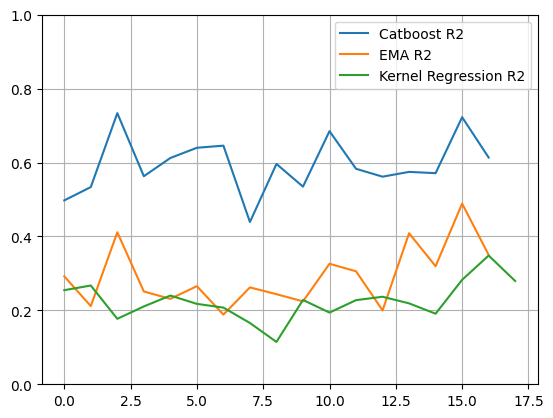

In [95]:
plt.plot(cb_scores, label="Catboost R2")
plt.plot(ema_scores, label="EMA R2")
plt.plot(ridge_scores, label="Kernel Regression R2")
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.show()